# Лабораторная работа №5. Цифровой спектральный анализ.

Курс: лаборатория цифровой обработки сигналов, ФРКТ МФТИ

#   Модуль 1. Окна в спектральном анализе методом ДПФ, алгоритмы вычисления ДПФ.

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
def DTFT(x, M):
    """
    Функция вычисляет значения ДВПФ в M точках на отрезке 
    по оси нормированных частот [-0.5; 0.5]

    Parameters
    ----------
    x : complex
        входная последовательность отсчетов, первый отсчет при k=0
    M : int
        количество точек на отрезке [-0.5; 0.5]

    Returns
    -------
    float
        значения оси нормированных частот, 
        соответствующих вычисленным значениям
        спектральной функции  
    complex
        значения спектральной функции      
    """
    return (np.fft.fftshift(np.fft.fftfreq(M, d=1)), np.fft.fftshift(np.fft.fft(x, M)))

In [4]:
# %matplotlib widget

### Инструменты
* Дискретное во времени преобразование Фурье (ДВПФ)  — спектр дискретизованного сигнала.
* Дискретное преобразование Фурье (ДПФ) для случая сигнала конечной длительности — выборки ДВПФ.
* Кратковременное дискретное преобразование Фурье (STFT).

### Эффекты
* Растекания спектральных компонент (Spectral leakage).
* Утечки спектра через боковые лепестки.
* Паразитная амплитудная модуляция спектра. 

### Вопрос о разрешении по частоте
* Дискретность сетки частот ДПФ.
* Ограниченная разрешающая способность окон.

### Алгоритмы вычисления ДПФ
* Быстрое преобразование Фурье (БПФ).
* Матричная форма ДПФ.
* Алгоритм Герцеля.
* Скользящее ДПФ. 


## Инструменты: ДВПФ и ДПФ

Рассмотрим $N$-точечную последовательность $x[k]$. Ее ДВПФ ($\Delta t$ - шаг дискретизации)
\begin{equation} 
X(\nu)= \sum_{k=0}^{N-1} x[k]       \exp\left(-j2\pi\nu k\right). 
\end{equation}

ДПФ для последовательности $ x[k]$, имеет следующий вид:
\begin{equation}
X[n]=\sum_{k=0}^{N-1} x[k] \exp\left(-j 2\pi\frac{n}{N}k\right).
\end{equation}
Сравнивая формулы, в точках $\nu = n/N$ получаем равенство
\begin{equation} 
\boxed{X(n \Delta \nu)=X[n], \;  \; \Delta \nu=1/N.}
\end{equation}
Это означает, что коэффициенты ДПФ $X[n]$ равны отсчетам функции $X(\nu)$, взятым с шагом $\Delta \nu=1/N$.

In [5]:
def example_Zero_Padding(Nz=0):
    # signal  
    N=16
    k=np.arange(N)
    x=np.sin(2*np.pi*2.1*k/16)+np.sin(2*np.pi*3.1*k/16)+np.sin(2*np.pi*5.6*k/16)

    # zero padding
    x=np.hstack((x, np.zeros(Nz)))
    N=N+Nz
    marker='.' if N>80 else 'o'
    # plot of signal
    figure1 = plt.figure(figsize=[8, 5], dpi=100)
    plt.subplot(2, 1, 2)
    
    plt.stem(np.arange(x.size), x, linefmt='b', markerfmt='b'+marker )
    plt.title(u'Сигнал $x[k]=\sin(2\pi k \\frac{2.1}{16})+\sin(2\pi k \\frac{3.1}{16})+\sin(2\pi k \\frac{5.6}{16})$, $k=0, 1, \dots, 15$', fontsize=14, pad=12)
    plt.xlabel(u'$k$')
    plt.ylabel(u'$x[k]$')
    plt.grid()
    # DTFT 
    plt.subplot(2, 1, 1)
    M=1024
    plt.plot(np.arange(M)/M, abs((np.fft.fft(x, M))), 'm')
    # DFT
    plt.stem(np.arange(N)/N, abs((np.fft.fft(x))), linefmt='g', markerfmt='g'+marker )
    plt.axis(xmin=0, xmax=1, ymin=0)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.title(u'ДВПФ и ДПФ$_{%i}$ сигнала $x[k]$ (один период)' %(N), fontsize=14, pad=12)
    plt.xlabel(u'$\\nu$')
    plt.ylabel(u'$|X(\\nu)|$')
    plt.annotate(u"$\mathbf{\dots}$", (0.01, 5))
    plt.annotate(u"$\mathbf{\dots}$", (0.96, 5))
    plt.grid()
    plt.tight_layout()
    plt.show()

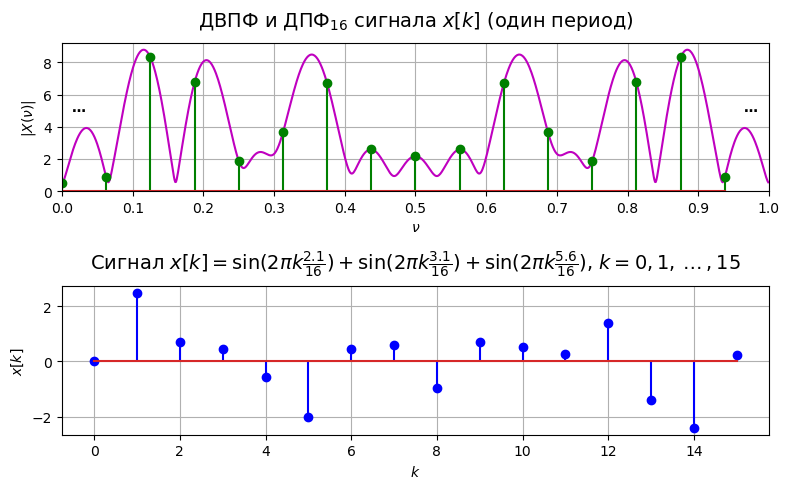

In [6]:
example_Zero_Padding(Nz=0)

## Интерполяция ДВПФ добавлением нулевых отсчетов в сигнал (Zero Padding)

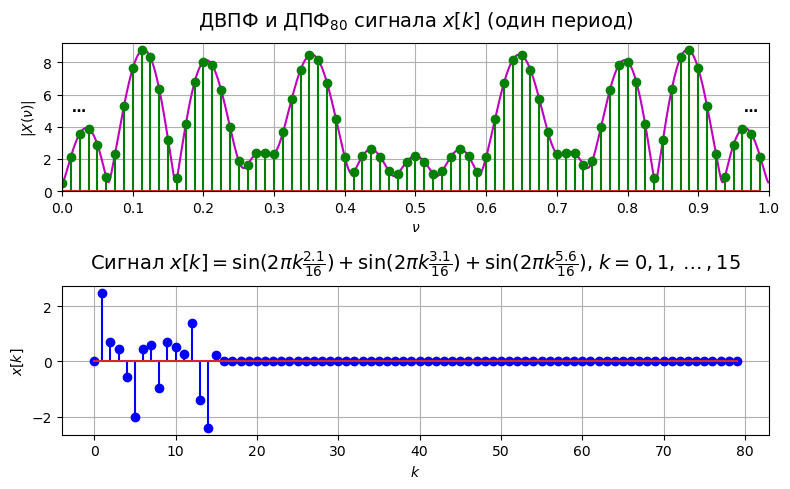

In [7]:
example_Zero_Padding(Nz=64)

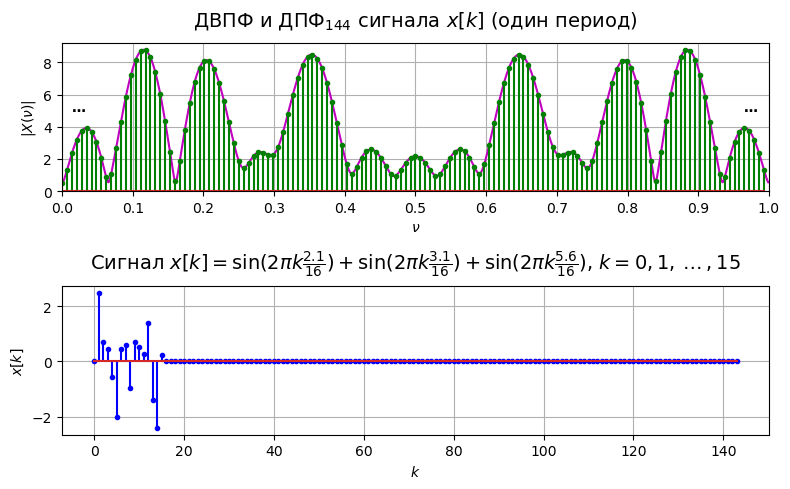

In [8]:
example_Zero_Padding(Nz=128)

## Эффект растекания спектральных компонент (Spectral leakage)

Эффект растекания спектральных компонент заключается в том, из-за того, что мы не можем наблюдать периодический сигнал в бесконечный интервал по времени $t\in(-\infty; \infty)$, мы наблюдаем в спектре не гармоники, а спектральные максимумы. 

Проиллюстрируем его на примере.

Предположим, что имеется периодическая последовательность ($\infty<k<+\infty$) 
 $x[k]=\cos \left( 2\pi \dfrac{3}{16} k \right).$ 


Учитывая, что $\cos(2\pi \frac{3}{16} k)=\frac{1}{2} \exp(j2\pi \frac{3}{16} k) +\frac{1}{2} \exp(-j2\pi \frac{3}{16} k)$, получаем для ДВПФ этой последовательности 
$$X(\nu)=\sum_{n=-\infty}^{\infty} \dfrac{1}{2}  \delta(\nu - \dfrac{3}{16}-n)+\dfrac{1}{2}  \delta(\nu + \dfrac{3}{16}-n).$$

Предположим, что нужно вычислить ДВПФ для одного периода последовательности $x[k]=\cos \left(2\pi \dfrac{3}{16} k \right)$, т.е. для последовательности $y[k]=x[k]w[k]$, где $w[k]=\sum_{m=0}^{15}\mathbf1[k-m]$.

ДВПФ прямоугольного окна:
$$W(\nu)=e^{-j(N-1)\pi\nu}\frac{\sin(N\pi \nu)}{\sin(\pi \nu)},$$
$$X(\nu)=0.5\sum_{m=-\infty}^{\infty} \delta(\nu-\frac{3}{16}-m)+0.5\sum_{m=-\infty}^{\infty} \delta(\nu+\frac{3}{16}-m).$$
**Способ 1.**  ДВПФ последовательности $Y(\nu)$ может быть представлено в виде циклической свертки 
$$Y(\nu)=\int_{-1/2}^{1/2} X(\widetilde\nu) W(\nu-\widetilde\nu) d\widetilde\nu=\int_{-1/2}^{1/2} W(\widetilde\nu) X(\nu-\widetilde\nu) d\widetilde\nu$$
Используя фильтрующее свойство дельта-функции
$$\begin{array}{l}\int_a^bW(\nu)\delta(\nu-\nu_1)d\nu=\left\{\begin{array}{l}W(\nu_1),\;a<\nu_1<b,\\0.5W(\nu_1),\;(\nu_1=a)\;\cup\;(\nu_1=b),\;\\0,\;(\nu_1<a)\;\cup\;(\nu_1>b),\end{array}\right.\end{array}$$
получаем, что
$$
Y(\nu)=0.5W(\nu-\frac{3}{16})+0.5W(\nu+\frac{3}{16}).
$$

**Способ 2.**   Аналогично через теорему смещения
$$y[k]=\left(\frac12\exp(j 2\pi k\frac{3}{16})+\frac12\exp(-j 2\pi k\frac{3}{16})\right)w[k],$$
$$
Y(\nu)=0.5W(\nu-\frac{3}{16})+0.5W(\nu+\frac{3}{16}).
$$
$$
Y(\nu)=\frac12\exp\left({-j(N-1)\pi(\nu-\frac{3}{16})}\right)\frac{\sin(N\pi (\nu-\frac{3}{16}))}{\sin(\pi (\nu-\frac{3}{16}))}+
              \frac12\exp\left({-j(N-1)\pi(\nu+\frac{3}{16})}\right)\frac{\sin(N\pi (\nu+\frac{3}{16}))} {\sin(\pi (\nu+\frac{3}{16}))}.
$$

In [9]:
def DTFT_abs(x, M):
    return (-0.5+(np.arange(M)/M), abs(np.fft.fftshift(np.fft.fft(x, M))))

def leakage_example(window='boxcar'):

    N=16
    k=np.arange(N)
    x=np.cos(2*np.pi*k*3/16);
    figure1 = plt.figure(figsize=[8, 7])

    plt.subplot(3, 2, 1)
    plt.title('Периодический сигнал $x[k]$')
    plt.stem(np.hstack([k-N, k, k+N]), np.hstack([x, x, x]), linefmt='y', markerfmt='yo' )
    plt.stem(k, x, linefmt='b', markerfmt='bo' )
    plt.grid()
    plt.xticks(np.arange(-16, 33, 8))
    plt.xlim([-17, 32])
    plt.annotate(u"$\mathbf{\dots}$", (29, 0.7))
    plt.annotate(u"$\mathbf{\dots}$", (-16.5, -0.4))
    plt.xlabel('$k$')
    plt.ylabel('$x[k]$')
    w = signal.get_window(window, N)
    y = x * w

    plt.subplot(3, 2, 3)
    plt.title('Сигнал $y[k]=x[k]w[k]$')
    plt.stem(k, y, linefmt='b', markerfmt='bo' )
    plt.grid()
    plt.xticks(np.arange(-16, 33, 8))
    plt.xlim([-17, 32])
    plt.xlabel('$k$')
    plt.ylabel('$y[k]$')
    plt.subplot(3, 2, 2)
    plt.stem([-3/16-1, -13/16, -3/16, 3/16, 13/16, 3/16+1], 
          [0.5, 0.5, 0.5, 0.5, 0.5, 0.5], markerfmt="^" )
    plt.axis(xmin=-1.5, xmax=1.5)
    plt.axis(ymin=0, ymax=0.6)
    plt.xticks([-1.5, -3/16-1, -13/16, -0.5, -3/16, 0, 3/16, 0.5, 13/16, 1, 19/16, 1.5], 
               ('-1.5', '$-\\dfrac{19}{16}$', '$-\\dfrac{13}{16}$','-0.5', '$-\\dfrac{3}{16}$', 
                '0', '$\\dfrac{3}{16}$','0.5',
                '$\\dfrac{13}{16}$', '1', '$\\dfrac{19}{16}$', '1.5'
                ))
    ar=u"(0.5)"
    plt.annotate(ar, (3/16+0.05, 0.45))
    plt.annotate(ar, (13/16+0.05, 0.45))
    plt.annotate(ar, (19/16+0.03, 0.45))
    plt.annotate(ar, (-3/16+0.05, 0.45))
    plt.annotate(ar, (-13/16+0.05, 0.45))
    plt.annotate(ar, (-19/16+0.05, 0.45))
    plt.annotate(u"$\mathbf{\dots}$", (-1.4, 0.25))
    plt.annotate(u"$\mathbf{\dots}$", (1.3, 0.25))
    plt.title('ДВПФ сигнала $x[k]$ при $-1.5 \\leq \\nu \\leq 1.5$')
    plt.xlabel(u'$\\nu$')
    plt.ylabel(u'$X(\\nu)$')
    plt.yticks([])

    plt.subplot(3, 2, 4)
    M=1024
    f1, Xn1 = DTFT_abs(y, M)
    f=np.hstack([f1-1, f1, f1+1])
    Xn=np.hstack([Xn1, Xn1, Xn1])
    plt.plot(f, Xn, 'g'); 
    plt.axis(xmin=-1.5, xmax=1.5, ymin=0)
    plt.xticks(np.arange(-0.5, 0.6, 0.25))
    plt.title(u'ДВПФ сигнала y$[k]$ при $-1.5 \\leq \\nu \\leq 1.5$') #, N=%i' %N)
    plt.xlabel(u'$\\nu$')
    plt.ylabel(u'$|Y(\\nu)|$')
    plt.xticks([-1.5, -3/16-1, 3/16-1, -0.5, -3/16, 
                0, 3/16, 0.5, 1-3/16, 1+3/16, 1.5], 
               ('-1.5', '$-\\dfrac{19}{16}$', '$-\\dfrac{13}{16}$', 
                '-0.5', '$-\\dfrac{3}{16}$','0',
                '$\\dfrac{3}{16}$','0.5', '$\\dfrac{13}{16}$', 
                '$\\dfrac{19}{16}$', '1.5'
                ))
    plt.annotate(u"$\mathbf{\dots}$", (-1.45, 5))
    plt.annotate(u"$\mathbf{\dots}$", (1.35, 5))
    plt.yticks([0, max(Xn1)//2, max(Xn1)])
    plt.grid()
    
    plt.subplot(3, 2, 5)
    plt.title('Окно $w[k]$')
    plt.stem(np.hstack([k-N, k, k+N]), np.hstack([np.zeros_like(w), w, np.zeros_like(w)]), linefmt='b', markerfmt='bo')
    plt.grid()
    plt.xticks(np.arange(-16, 33, 8))
    plt.xlim([-17, 32])
    plt.annotate(u"$\mathbf{\dots}$", (29, 0.7))
    plt.annotate(u"$\mathbf{\dots}$", (-16.5, -0.4))
    plt.xlabel('$k$')
    plt.ylabel('$w[k]$') 
    
    plt.subplot(3, 2, 6)
    M=1024
    f1, W1 = DTFT_abs(w, M)
    plt.plot(np.hstack([f1-1, f1, f1+1]), np.hstack([W1, W1, W1]), 'g'); 
    plt.axis(xmin=-1.5, xmax=1.5, ymin=0)
    plt.xticks(np.arange(-0.5, 0.6, 0.25))
    plt.title(u'АЧХ окна $w[k]$ при $-1.5 \\leq \\nu \\leq 1.5$') #, N=%i' %N)
    plt.xlabel(u'$\\nu$')
    plt.ylabel(u'$|W(\\nu)|$')
    plt.xticks([-1.5, -0.5, 0, 0.5, 1.5], 
               ('-1.5', '-0.5', '0', '0.5', '1.5'))
    plt.annotate(u"$\mathbf{\dots}$", (-1.45, 5))
    plt.annotate(u"$\mathbf{\dots}$", (1.35, 5))
    plt.yticks([0, max(W1)//2, max(W1)])
    plt.grid()
    
    plt.tight_layout()
    plt.show()

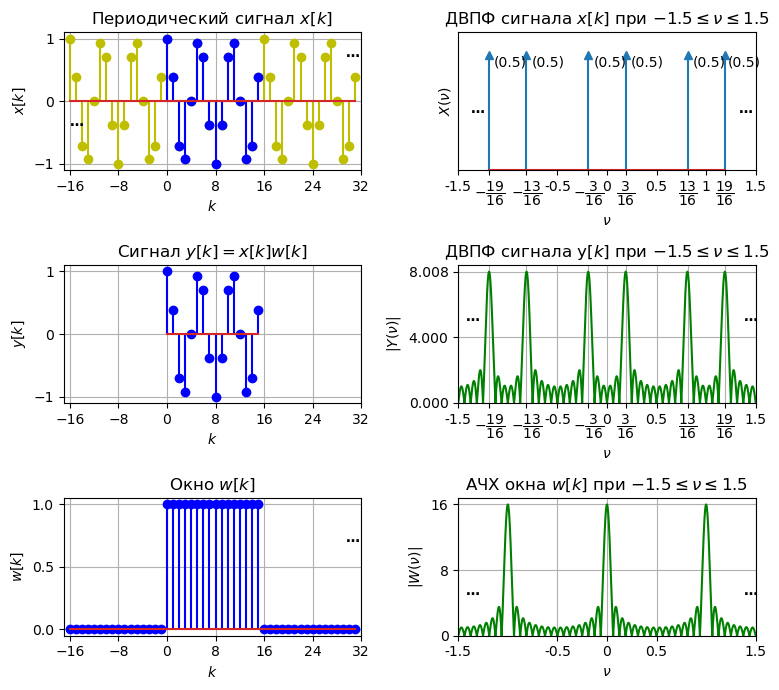

In [10]:
leakage_example(window='boxcar')

## Эффект утечки спектра через боковые лепестки

Как видно из предыдущего примера, при анализе отрезка периодического сигнала, помимо главных спектральных максимумов, мы наблюдаем боковые максимумы, частоты которых не отвечают гармоникам сигнала. 

Физик Франц Артур Фридрих Шустер (нем. Franz Arthur Friedrich Schuster; 1851—1934), создатель периодограммного метода оценки СПМ (который мы изучим далее), называл их "ложными периодичностями". Многие исследователи его времени ошибочно утверждали, эти максимумы обусловлены скрытыми периодичностями в сигнале. Шустер увидел здесь аналогию с дифракционными полосами в оптическом спектроскопе, которые возникали из-за ограниченной апертуры прибора.

Эффект утечки спектра можно ослабить путем применения оконной функции, отличной от прямоугольной. В качестве примера рассмотрим окно Ханна. Предположим, что нужно вычислить ДВПФ для одного периода последовательности $x[k]=\cos \left(2\pi \dfrac{3}{16} k \right)$, т.е. для последовательности $y[k]=x[k]w[k]$, где

$$
w[k]=\left\{\begin{array}{l}
\dfrac{1}{2} (1-\cos\dfrac{2\pi k}{N}), \; 0 \leq k < N,
\\
0, \{k<0\} \cup \{k\geq N\};
\end{array}\right.
$$

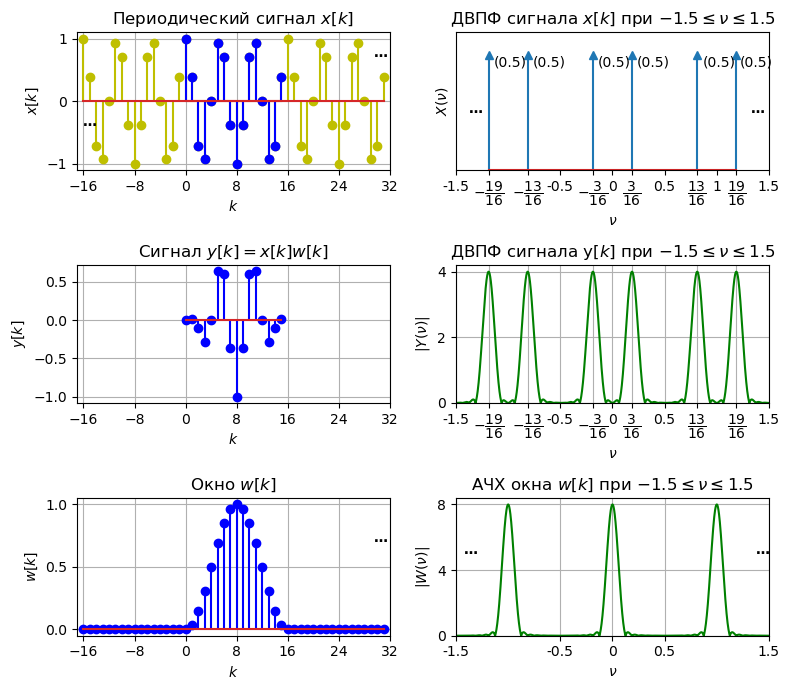

In [11]:
leakage_example(window='hann')

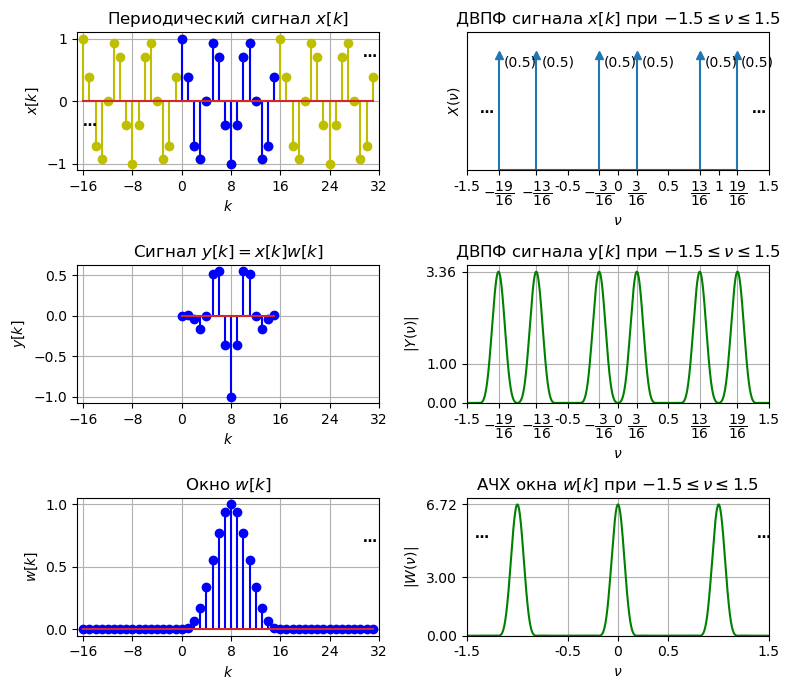

In [12]:
leakage_example(window='blackman')

## Сводная таблица основных характеристик различных оконных функций

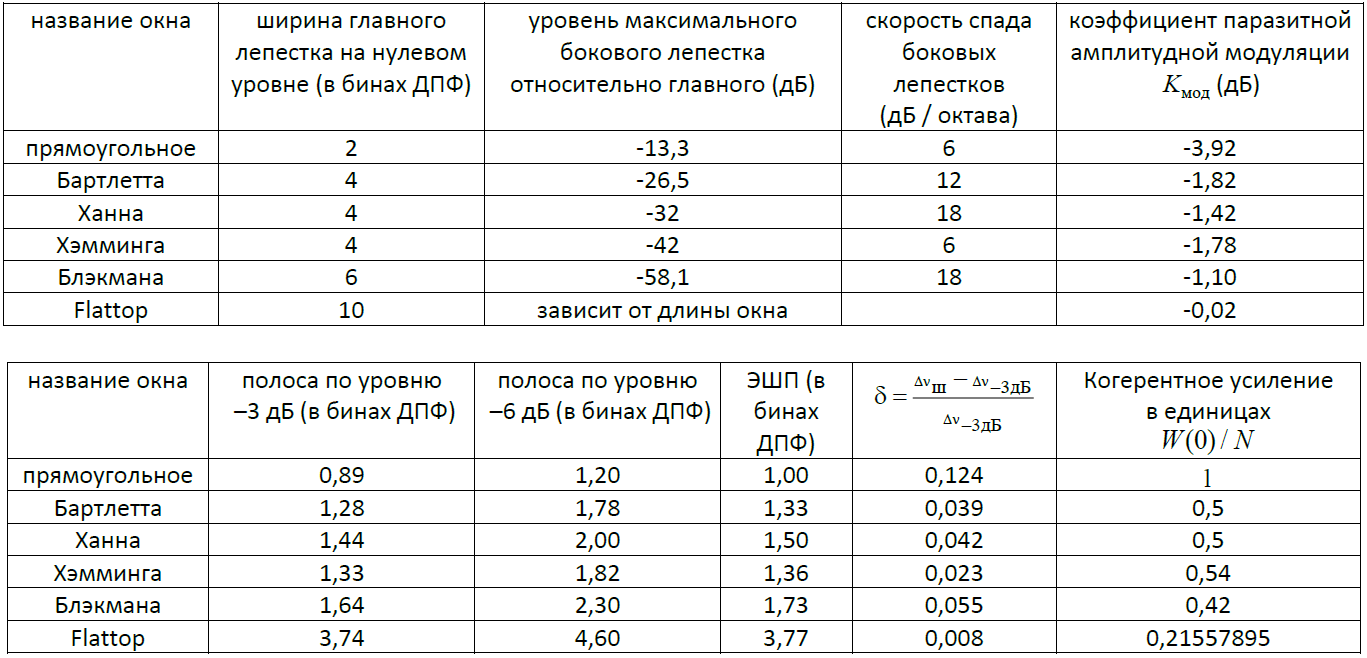

## Ограниченная разрешающая способность окон (различение двух близких гармоник).

### Пример. Взвешивание прямоугольным окном.

$x[k] =   \cos \left( 2 \pi \dfrac{17}{N} k\right) + \cos \left( 2 \pi \dfrac{18,5}{N} k\right)$  — анализируемая последовательность

$w[k]$ — прямоугольное окно

$y[k] = x[k]w[k]$  — взвешанная последовательность

$\nu_1 = \dfrac{17}{N}$,  $\nu_2 = \dfrac{18,5}{N}$, $\nu_{12}=|\nu_2-\nu_1|=\dfrac{1,5}{N}$ (1,5 бина ДПФ)

In [13]:
N=64
k=np.arange(N)
x=np.cos(2*np.pi*k*17/N) + np.cos(2*np.pi*k*18.5/N)

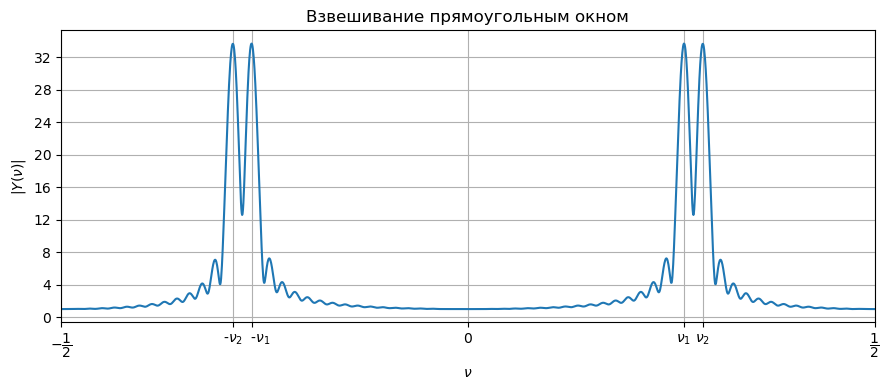

In [14]:
nu, Xn = DTFT(x, M=2048)

plt.figure(figsize=[9, 4])
plt.title('Взвешивание прямоугольным окном')
plt.plot(nu, abs(Xn))
plt.xlabel('$\\nu$')
plt.ylabel('$|Y(\\nu)|$')
plt.xlim([-0.5, 0.5])
plt.xticks([-0.5, -18.5/N, -17/N, 0, 17/N, 18.5/N, 0.5], labels=("$-\dfrac{1}{2}$", "-$\\nu_2$", "    -$\\nu_1$", 
                                                                 "0", "$\\nu_1$", "$\\nu_2$", "$\dfrac{1}{2}$"))
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=4))
plt.grid()
plt.tight_layout()

* Для прямоугольного окна $\nu_{12}>\nu_{-6 дБ}$. Спектральные компоненты различимы в ДВПФ. 

$x[k] =   \cos \left( 2 \pi \dfrac{17}{N} k\right) + \cos \left( 2 \pi \dfrac{18,5}{N} k\right)$ 
$x[k] =   \dfrac{1}{2} \exp \left( j 2 \pi \dfrac{17}{N} k\right) + \dfrac{1}{2} \exp \left( -j 2 \pi \dfrac{17}{N} k\right)  + \dfrac{1}{2} \exp \left(j 2 \pi \dfrac{18,5}{N} k\right) + \dfrac{1}{2} \exp \left(-j 2 \pi \dfrac{18,5}{N} k\right)$  

* $W(0)/64 =1$, откуда $W(0) = 64$.

* Высота максимумов отличается от $W(0)/2 = 32$ из-за влияния боковых лепестков окна.
* При 64-точечном ДПФ растояние между отсчетами $1/64$, $\nu_{12}=1,5/64$. В ДПФ спектральные компоненты могут быть не различимы. 

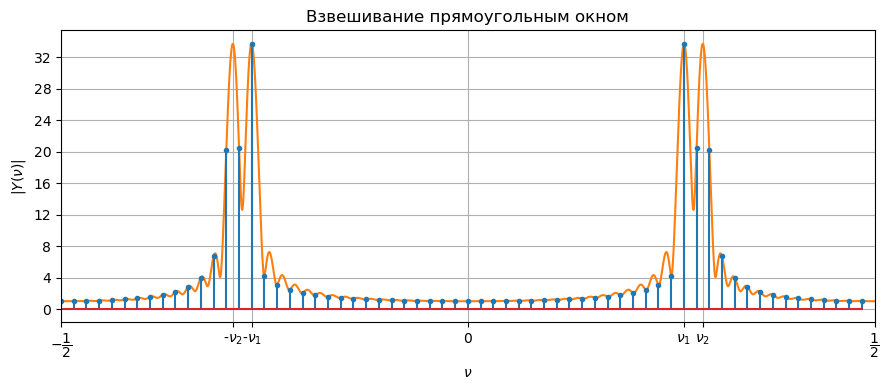

In [15]:
nu, Xn = DTFT(x, M=2048)
Nz=0
plt.figure(figsize=[9, 4])
plt.title('Взвешивание прямоугольным окном')
plt.plot(nu, abs(Xn), 'C1')

nu, Xn = DTFT(x, M=64+Nz)
plt.stem(nu, abs(Xn), linefmt='C0-', markerfmt='C0.')
plt.xlabel('$\\nu$')
plt.ylabel('$|Y(\\nu)|$')
plt.xlim([-0.5, 0.5])
plt.xticks([-0.5, -18.5/N, -17/N, 0, 17/N, 18.5/N, 0.5], labels=("$-\dfrac{1}{2}$", "-$\\nu_2$", "-$\\nu_1$", 
                                                                 "0", "$\\nu_1$", "$\\nu_2$", "$\dfrac{1}{2}$"))
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=4))
plt.grid()
plt.tight_layout()

### Пример. Взвешивание окном Блэкмана.

$x[k] =   \cos \left( 2 \pi \dfrac{17}{N} k\right) + \cos \left( 2 \pi \dfrac{18,5}{N} k\right)$  — анализируемая последовательность

$w[k]$ —  окно Блэкмана

$y[k] = x[k]w[k]$  — взвешанная последовательность

$\nu_1 = \dfrac{17}{N}$,  $\nu_2 = \dfrac{18,5}{N}$, $\nu_{12}=|\nu_2-\nu_1|=\dfrac{1,5}{N}$ (1,5 бина ДПФ)

* Для окна Блэкмана $\nu_{12}<\nu_{-3 дБ}$. Спектральные компоненты неразличимы в ДВПФ. 

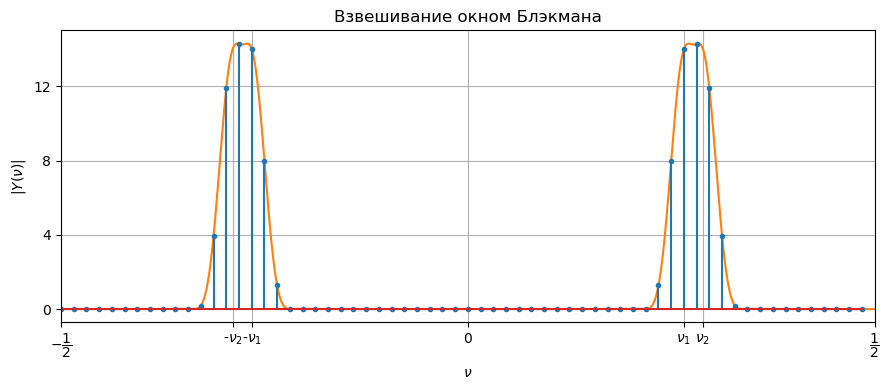

In [16]:
Nz=0
y=x*signal.windows.blackman(M=N, sym=False)
nu, Xn = DTFT(y, M=2048)

plt.figure(figsize=[9, 4])
plt.title('Взвешивание окном Блэкмана')
plt.plot(nu, abs(Xn), 'C1')

nu, Xn = DTFT(y, M=64+Nz)
#nu, Xn = DFT(y, M=64)
plt.stem(nu, abs(Xn), linefmt='C0-', markerfmt='C0.')
plt.xlabel('$\\nu$')
plt.ylabel('$|Y(\\nu)|$')
plt.xlim([-0.5, 0.5])
plt.xticks([-0.5, -18.5/N, -17/N, 0, 17/N, 18.5/N, 0.5], labels=("$-\dfrac{1}{2}$", "-$\\nu_2$", "-$\\nu_1$", 
                                                                 "0", "$\\nu_1$", "$\\nu_2$", "$\dfrac{1}{2}$"))
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=4))
plt.grid()
plt.tight_layout()

## Окна для спектрального анализа (окна для ДПФ).

In [17]:
def plot_window(w):
    plt.figure(figsize=[8, 3], dpi=120)
    plt.subplot(1, 3, 1)
    k=np.arange(N)
    plt.stem(k, w)
    plt.xlabel('$k$')
    plt.ylabel('$w[k]$')
    nu, Wn = DTFT(w, M=16*2048)
    plt.subplot(1, 3, 2)
    k=np.arange(N)
    plt.plot(nu, abs(Wn))
    plt.xlabel('$\\nu$')
    plt.ylabel('$|W(\\nu)|$')
    plt.grid()
    plt.subplot(1, 3, 3)
    k=np.arange(N)
    with np.errstate(divide='ignore'):
        plt.plot(nu, 20*np.log10(abs(Wn)/max(abs(Wn))))
    plt.ylim(ymin=-100)
    plt.grid()
    plt.xlabel('$\\nu$')
    plt.ylabel('$20 \lg \; |W(\\nu)\; / \;W(0)|$, дБ')
    plt.tight_layout()

### Прямоугольное окно

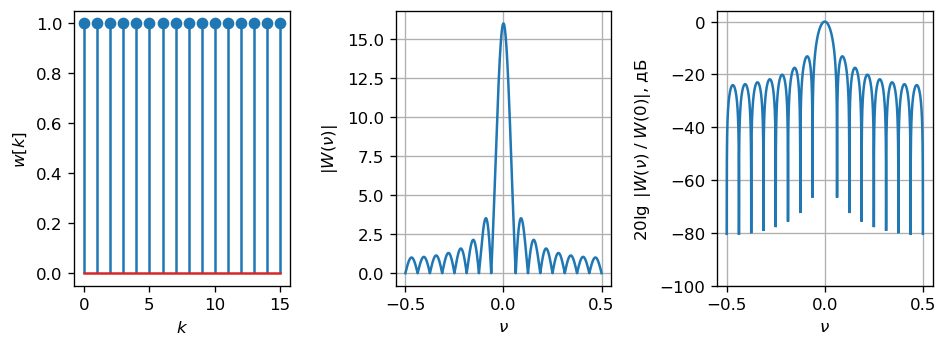

In [18]:
N=16 #*2
w=signal.windows.boxcar(M=N, sym=False)
plot_window(w)

Основные характеристики прямоугольного окна длиной $N$:
*  ширина главного лепестка на нулевом уровне $\Delta \nu = \dfrac{2}{N}$;
*  полоса по уровню $-3$ дБ составляет $\Delta \nu =\dfrac{0,89}{N}$;
*  уровень максимального бокового лепестка относительно главного составляет $-13,3$ дБ;
*  скорость спада боковых лепестков $6$ дБ / октава. 

Окта́ва — интервал частот, в котором соотношение граничных частот составляет один к двум. 
Например, расстояние между частотами $\nu_1=0.1$ и $\nu_2=0.2$ составляет одну октаву.

### Окно Бартлетта

$$
w[k]=\left\{\begin{array}{l}
1-\dfrac{2|k-N/2|}{N}, \; 0 \leq k < N,
\\
0, \{k<0\} \cup \{k\geq N\};
\end{array}\right.
$$

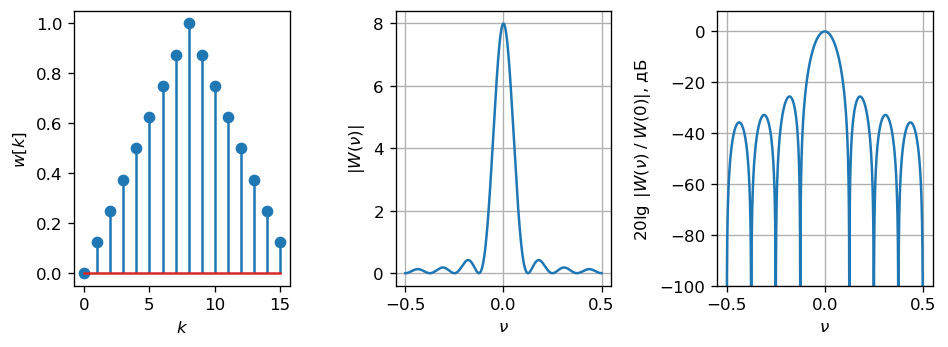

In [19]:
N=16 
w=signal.windows.bartlett(M=N, sym=False)
plot_window(w)

Основные характеристики окна Бартлетта длиной $N$:
*  ширина главного лепестка на нулевом уровне $\Delta \nu = \dfrac{4}{N}$;
*  полоса по уровню $-3$ дБ составляет $\Delta \nu =\dfrac{1,28}{N}$;
*  уровень максимального бокового лепестка относительно главного составляет $-26,5$ дБ;
*  скорость спада боковых лепестков $12$ дБ / октава. 

### Окно Ханна

$$
w[k]=\left\{\begin{array}{l}
\dfrac{1}{2} (1-\cos\dfrac{2\pi k}{N}), \; 0 \leq k < N,
\\
0, \{k<0\} \cup \{k\geq N\};
\end{array}\right.
$$

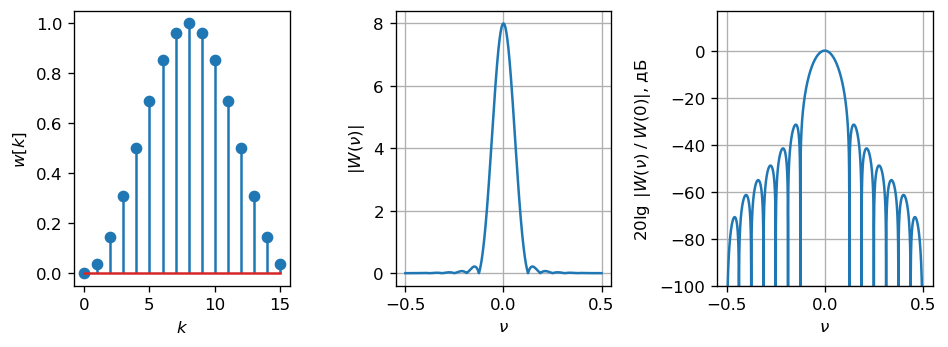

In [20]:
N=16 
w=signal.windows.hann(M=N, sym=False)
plot_window(w)

Основные характеристики окна  Ханна длиной $N$:
*  ширина главного лепестка на нулевом уровне $\Delta \nu = \dfrac{4}{N}$;
*  полоса по уровню $-3$ дБ составляет $\Delta \nu =\dfrac{1,44}{N}$;
*  уровень максимального бокового лепестка относительно главного составляет $-31,5$ дБ;
*  скорость спада боковых лепестков $18$ дБ / октава. 

### Окно Хэмминга

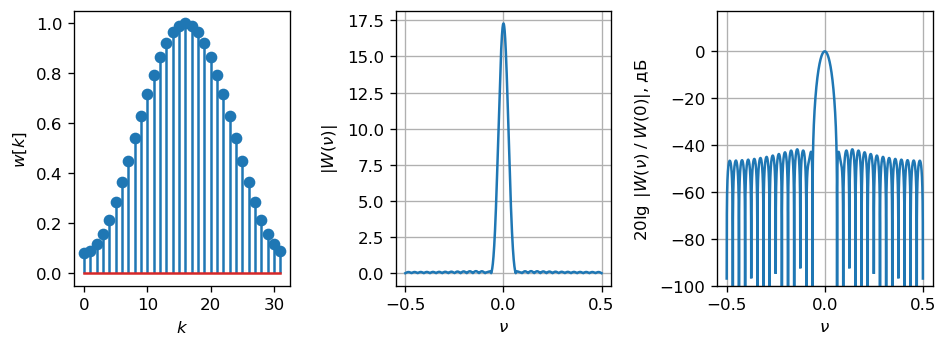

In [21]:
N=32 
w=signal.windows.hamming(M=N, sym=False)
plot_window(w)

$$
w[k]=\left\{\begin{array}{l}
0.54-0.46\cos\dfrac{2\pi k}{N}, \; 0 \leq k < N,
\\
0, \{k<0\} \cup \{k\geq N\};
\end{array}\right.
$$

Основные характеристики окна Хэмминга длиной $N$:
*  ширина главного лепестка на нулевом уровне $\Delta \nu = \dfrac{4}{N}$;
*  полоса по уровню $-3$ дБ составляет $\Delta \nu =\dfrac{1,36}{N}$;
*  уровень максимального бокового лепестка относительно главного составляет $-42$ дБ;
*  скорость спада боковых лепестков $6$ дБ / октава. 

### Окно Блэкмана

$$
w[k]=\left\{\begin{array}{l}
0.42-0.5\cos\dfrac{2\pi k}{N}+0.08\cos\dfrac{4\pi k}{N}, \; 0 \leq k < N,
\\
0, \{k<0\} \cup \{k\geq N\};
\end{array}\right.
$$

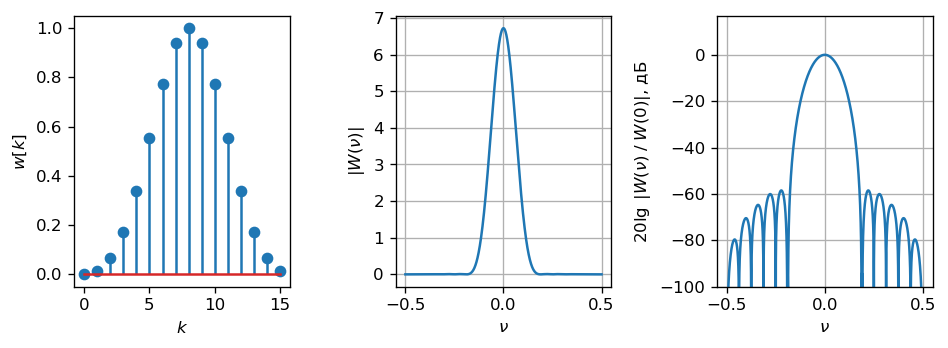

In [22]:
N=16 
w=signal.windows.blackman(M=N, sym=False)
plot_window(w)

Основные характеристики окна Блэкмана длиной $N$:
*  ширина главного лепестка на нулевом уровне $\Delta \nu = \dfrac{6}{N}$;
*  уровень максимального бокового лепестка относительно главного составляет $-58$ дБ.

### Окно Чебышёва (равноволновое)


*Свойство окна Чебышёва с максимальным уровнем боковых лепестков $a_{max}$ дБ*: из всех дискретных окон длиной $N$ с максимальным  уровнем боковых лепестков не более $a_{max}$ оно имеет самый узкий главный лепесток.

Рассмотрим симметричное окно (`sym=True`). Параметр `at` соотвествует уровню боковых лепестков.

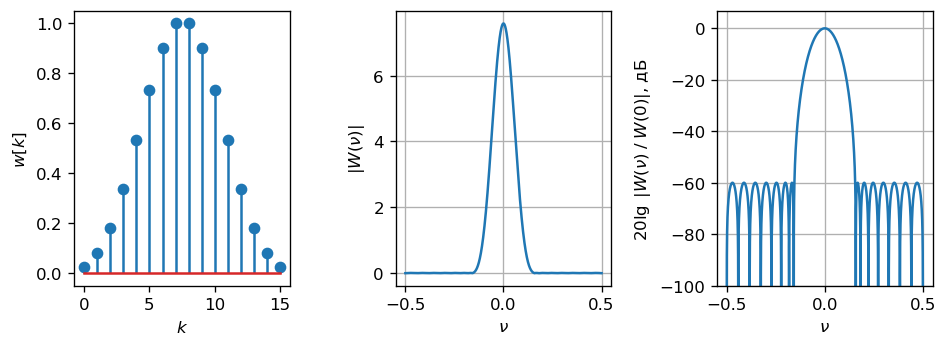

In [22]:
N=16
w=signal.windows.chebwin(M=N, at=60, sym=True)
plot_window(w)

### Окно Кайзера

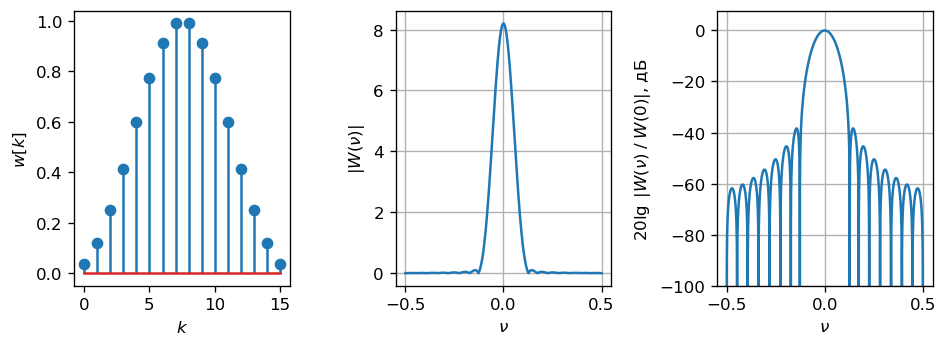

In [23]:
N=16 
w=signal.windows.kaiser(M=N, beta=5, sym=True)
plot_window(w)

Пример загрузки описания библиотечной функции. 

In [24]:
help(signal.windows.kaiser)

Help on function kaiser in module scipy.signal.windows._windows:

kaiser(M, beta, sym=True)
    Return a Kaiser window.
    
    The Kaiser window is a taper formed by using a Bessel function.
    
    Parameters
    ----------
    M : int
        Number of points in the output window. If zero, an empty array
        is returned. An exception is thrown when it is negative.
    beta : float
        Shape parameter, determines trade-off between main-lobe width and
        side lobe level. As beta gets large, the window narrows.
    sym : bool, optional
        When True (default), generates a symmetric window, for use in filter
        design.
        When False, generates a periodic window, for use in spectral analysis.
    
    Returns
    -------
    w : ndarray
        The window, with the maximum value normalized to 1 (though the value 1
        does not appear if `M` is even and `sym` is True).
    
    Notes
    -----
    The Kaiser window is defined as
    
    .. math::  w(n) = 

### Окно с плоской вершиной (Flattop)

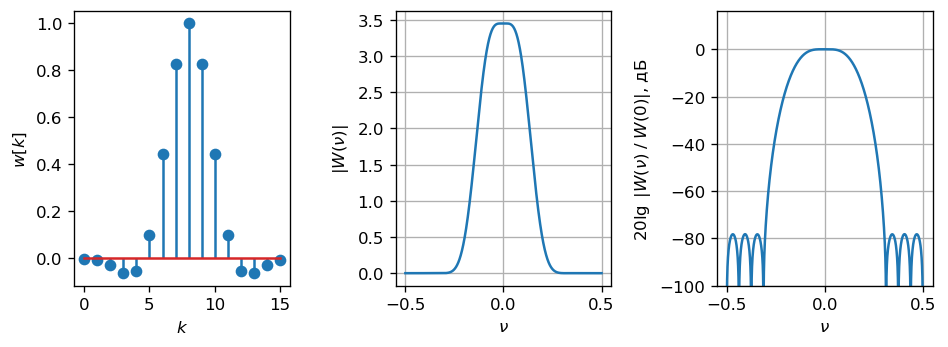

In [25]:
N=16#*2
w=signal.windows.flattop(M=N, sym=False)
plot_window(w)

## Амплитудная модуляция спектра.

Рассмотрим 32-точечный сигнал ($k=0,\;1,\;\dots, 31$)
$$x[k]=\cos\left( 2 \pi k \dfrac{9.5}{32}\right)=\frac{1}{2}\exp\left({j2 \pi k \dfrac{9.5}{32}}\right)+\frac{1}{2}\exp\left({-j2 \pi k \dfrac{9.5}{32}}\right)$$
* Пусть $y[k]=x[k]w[k]$, где $w[k]$ — некоторое окно. ДВПФ сигнала $y[k]$ 
$$Y(\nu)=\dfrac{1}{2} W\left(\nu- \dfrac{9.5}{32} \right)+\dfrac{1}{2} W\left(\nu+ \dfrac{9.5}{32} \right).$$
Чтобы высоты максимумов на графике ДВПФ соответствовали амплитудам гармоник, нужно нормировать ось ординат на $W(0)$.
* Если выбрать прямоугольное окно, `w = signal.get_window('boxcar', N)`, то оценки амплитуд, получаемые с помощью ДПФ$_{32}$, ,будут отличаться от истинных значений на $-3,92$ дБ (значение коэффициента паразитной амплитудной модуляции). 
* Результат можно исправить, дополняя сигнал нулевыми отсчетами и увеличивая размерность ДПФ. 
* Без изменения размерности ДПФ лучшего результата можно добиться с помощью окна с плоской вершиной `w = signal.get_window('flattop', N)`.
* В реальности часто частоты гармоник неизвестны. Поэтому для оценки амплитуд используются окна с низким коэффициентом паразитной амплитудной модуляции (например, flattop-окно).

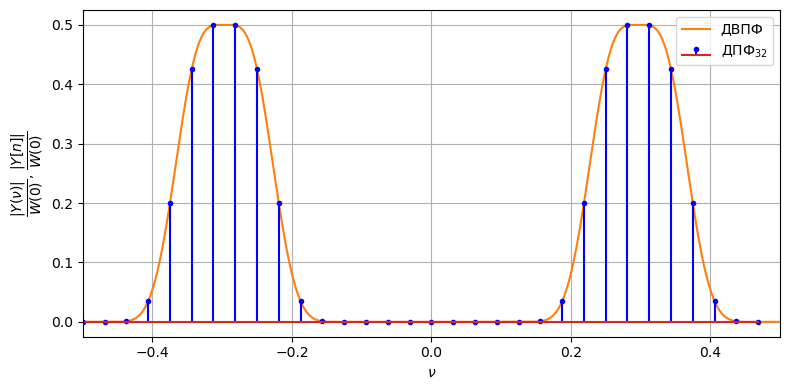

In [26]:
N=64
N_dtft=2**14
N=32
N_dft=32
k=np.arange(N)
x=np.cos(2*np.pi*9.5/N*k)
from scipy import signal
# w = signal.get_window('boxcar', N)
# w = signal.get_window('blackman', N)
# w = signal.get_window(('kaiser', 8), N)
w = signal.get_window('flattop', N)
y = x * w
W0 = sum(w)


nu_dtft, X_dtft = np.linspace(-0.5, 0.5, num=N_dtft, endpoint=False), np.fft.fftshift(np.fft.fft(y, N_dtft))
nu_dft, X_dft = np.linspace(-0.5, 0.5, num=N_dft, endpoint=False), np.fft.fftshift(np.fft.fft(y, N_dft))


plt.figure(figsize=[8, 4], dpi=100)
plt.plot(nu_dtft, abs(X_dtft)/W0, 'C1', label='ДВПФ')
plt.stem(nu_dft, abs(X_dft)/W0, linefmt='b', markerfmt='.b', label='ДПФ$_{%i}$' % N_dft)
plt.xlabel('$\\nu$')
plt.ylabel('$\dfrac{|Y(\\nu)|}{W(0)}$, $\dfrac{|Y[n]|}{W(0)}$')
plt.xlim([-0.5, 0.5])
plt.legend()
plt.grid()
plt.tight_layout()

### Маскировка слабых гармоник боковыми лепестками окна

In [27]:
fs=10000
f0=2000
f1=2390
a1=40
a2=1
a=4
N=128
k=np.arange(N)

x=a1*np.sin(2*np.pi*f0/fs*k)+a2*np.sin(2*np.pi*f1/fs*k)

$$ x[k] = 40 \sin(2\pi \nu_0 k) + \sin(2\pi\nu_1 k) $$
где $\nu_0=f_0 / f_s$, $\nu_1=f_1 / f_s$.

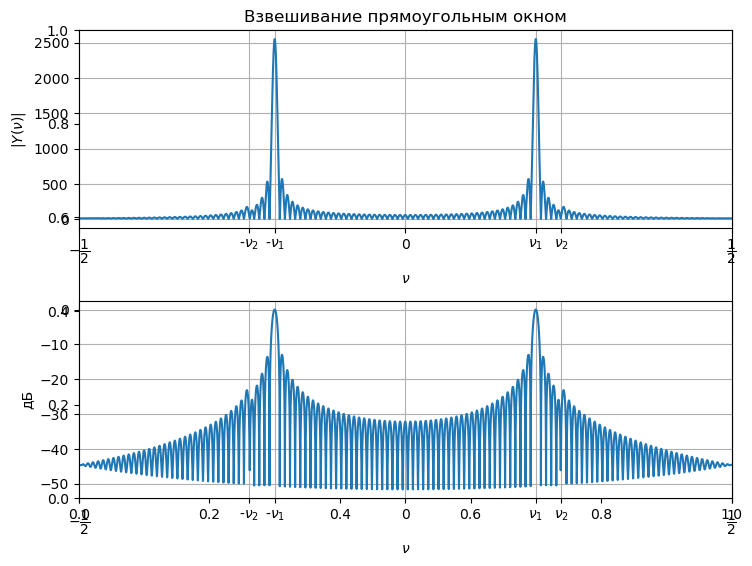

In [28]:
nu, Xn = DTFT(x, M=2**16)
plt.figure(figsize=[8, 6])
plt.title('Взвешивание прямоугольным окном')
plt.subplot(2, 1, 1)
plt.plot(nu, abs(Xn))
plt.xticks([-0.5, -f1/fs, -f0/fs, 0, f0/fs, f1/fs, 0.5], labels=("$-\dfrac{1}{2}$", "-$\\nu_2$", "-$\\nu_1$",                                                         "0", "$\\nu_1$", "$\\nu_2$", "$\dfrac{1}{2}$"))
plt.xlabel('$\\nu$')
plt.ylabel('$|Y(\\nu)|$')
plt.xlim([-0.5, 0.5])
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(nu, 20*np.log10(abs(Xn)/max(abs(Xn))))
plt.xticks([-0.5, -f1/fs, -f0/fs, 0, f0/fs, f1/fs, 0.5], labels=("$-\dfrac{1}{2}$", "-$\\nu_2$", "-$\\nu_1$",                                                         "0", "$\\nu_1$", "$\\nu_2$", "$\dfrac{1}{2}$"))
plt.xlabel('$\\nu$')
plt.ylabel('дБ')
plt.xlim([-0.5, 0.5])
plt.grid()
plt.tight_layout()

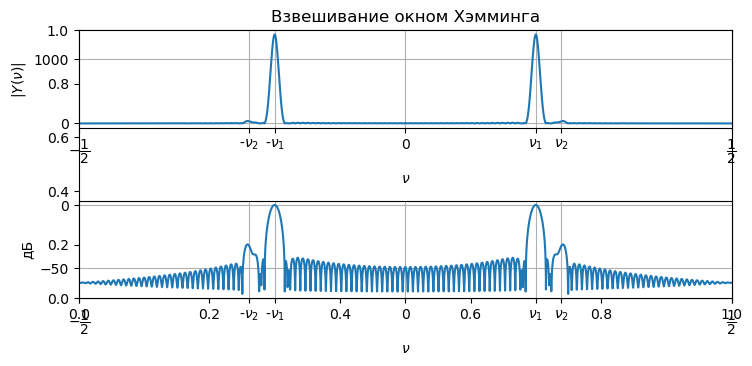

In [29]:
nu, Xn = DTFT(x*signal.windows.hamming(M=x.size, sym=False), M=2**16)
plt.figure(figsize=[8, 4])
plt.title('Взвешивание окном Хэмминга')
plt.subplot(2, 1, 1)
plt.plot(nu, abs(Xn))
plt.xticks([-0.5, -f1/fs, -f0/fs, 0, f0/fs, f1/fs, 0.5], labels=("$-\dfrac{1}{2}$", "-$\\nu_2$", "-$\\nu_1$",                                                         "0", "$\\nu_1$", "$\\nu_2$", "$\dfrac{1}{2}$"))
plt.xlabel('$\\nu$')
plt.ylabel('$|Y(\\nu)|$')
plt.xlim([-0.5, 0.5])
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(nu, 20*np.log10(abs(Xn)/max(abs(Xn))))
plt.xticks([-0.5, -f1/fs, -f0/fs, 0, f0/fs, f1/fs, 0.5], labels=("$-\dfrac{1}{2}$", "-$\\nu_2$", "-$\\nu_1$",                                                         "0", "$\\nu_1$", "$\\nu_2$", "$\dfrac{1}{2}$"))
plt.xlabel('$\\nu$')
plt.ylabel('дБ')
plt.xlim([-0.5, 0.5])
plt.grid()
plt.tight_layout()

## Алгоритмы вычисления ДПФ

Через множители $W_{N}^{\,nk}$ пара ДПФ записывается в виде
$$X[n]=\sum\limits_{k=0}^{N-1}{x}[k]W_{N}^{\,nk},$$
$$x[k]=\frac{1}{N}\sum\limits_{n=0}^{N-1}{X}[n]W_{N}^{\,-nk}.$$
где
$W_{N}^{\,nk}=\text{exp}(-j\frac{2\pi }{N}n\,k),\ \ \ n,\,k\in 0,\,1,\,2,\ \ \ldots ,\ N-1.$


In [30]:
N=64
k=np.arange(N)
x=np.cos(2*np.pi*k*17/N) + np.sin(2*np.pi*k*18.5/N)

### Быстрое преобразование Фурье

* Быстрое преобразование Фурье (БПФ, англ. FFT) представляет собой эффективный метод вычисления дискретного преобразования Фурье (ДПФ). 
* Его эффективность заключается в существенном уменьшении числа операций умножения и суммирования, затрачиваемых для получения всех $N$  коэффициентов ДПФ.  
* Алгоритмы БПФ позволяют заметно сократить число операций при вычислении всех коэффициентов ДПФ для некоторых размерностей $N$. Например, если $N$ является степенью числа $2$, то асимптотическая сложность алгоритма БПФ $O\left( N{{\log }_{2}}N \right)$.

In [31]:
Xn1 = np.fft.fft(x, N)

### Матричная форма ДПФ


В матричной форме пара ДПФ (с нормирующим множителем в обратном преобразовании) имеет вид
$$\vec{X}={{\left[ W \right]}_{N}}\,\vec{x},$$
$$\vec{x}={{\left[ {{W}_{N}} \right]}^{-1}}\vec{X},$$ 
$$\vec{X}=\left[ \begin{matrix}
   X[0]  \\
   X[1]  \\
   \vdots   \\
   X[N-1]  \\
\end{matrix} \right],\quad \vec{x}=\left[ \begin{matrix}
   x[0]  \\
   x[1]  \\
   \vdots   \\
   x[N-1]  \\
\end{matrix} \right].$$

Чтобы найти обратную матрицу ${{\left[ {{W}_{N}} \right]}^{-1}}$, достаточно заметить, что 
$$\frac{1}{N}{{\left[ {{W}_{N}} \right]}^{*}}\ \left[ {{W}_{N}} \right]={{I}_{N}},$$
где ${{I}_{N}}$– единичная матрица размером $N\times N.$ В итоге получаем, что ${{\left[ {{W}_{N}} \right]}^{-1}}=\frac{1}{N}{{\left[ {{W}_{N}} \right]}^{*}},$
т.е. для нахождения обратной матрицы достаточно выполнить комплексное сопряжение для $\left[ {{W}_{N}} \right]$ и нормировать результат на $N$.


* Функция ```scipy.linalg.dft(N)``` возвращает матрицу ДПФ размерности $N$. 

In [32]:
from scipy.linalg import dft
W = dft(N)
Xn2 = W @ x

Сравним результаты. 

In [33]:
max(abs(Xn1-Xn2))

4.0110169946265163e-13

### Алгоритм Гёрцеля

* Алгоритмы БПФ наиболее хорошо работают, когда нужно определить все $N$ коэффициентов ДПФ. Однако практически часто достаточно знать только часть из $N$ отсчётов ДПФ. В этом случае более эффективными могут оказаться другие алгоритмы. Примером является  алгоритм Гёрцеля.

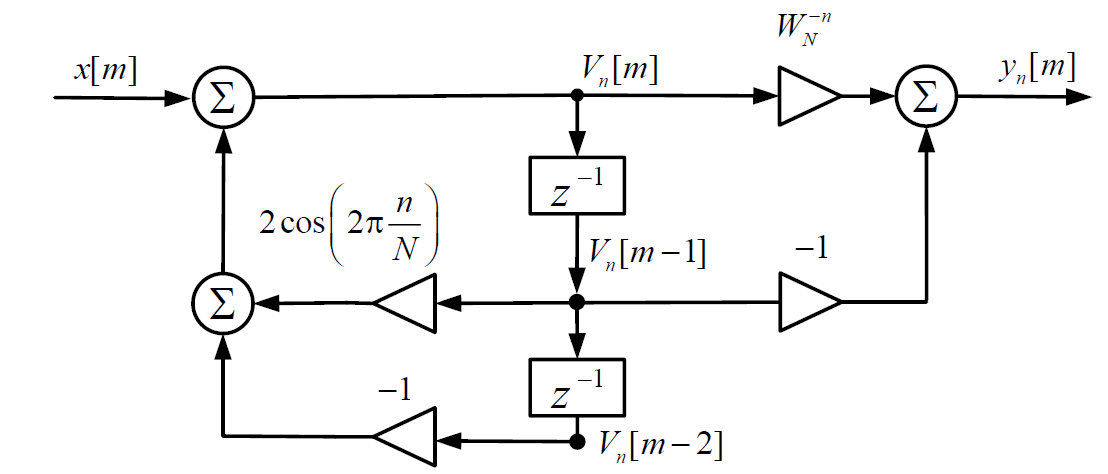

$${{y}_{n}}[m]=W_{N}^{-n}x[m]-x[m-1]+2\cos (2\pi n/N){{y}_{n}}[m-1]-{{y}_{n}}[m-2].$$

**Алгоритм Герцеля**

1) Для $m=0,\,1,\, \dots,\, N-1$ определяем 

$${{V}_{n}}[m]=x[m]+2\cos (2\pi n/N){{V}_{n}}[m-1]-{{V}_{n}}[m-2],\quad 0\le m\le N-1,$$

2) Вычисляем $X[n]$ (при $m=N-1$):

$$X[n]={{\left. {{y}_{n}}[m] \right|}_{m=N-1}}={{\left. \left( W_{N}^{-n}{{V}_{n}}[m]-{{V}_{n}}[m-1] \right) \right|}_{m=N-1}}.$$
$$V_n[-1]=V_n [-2] = 0$$


**Примечание.** Расчет выхода фильтра для всех первых $N$ в самом алгоритме Герцеля не требуется. В задании лабораторной работы требуется написать код для алгоритма, представленного выше.

In [34]:
from scipy import signal
n=18 

def w(n, k=1, N=2):
    return np.exp(-2j*np.pi*n*k/N)


beta=np.array([w(n=-n, k=1, N=N), -1.0], dtype=complex)
alpha=np.array([1.0, -2.0*np.cos(2*np.pi*n/N), 1.0], dtype=complex)


y = signal.lfilter(beta, alpha, x)
y[N-1]

(20.255463181383096-8.171241461241152e-14j)

Сравним с результатом БПФ

In [35]:
Xn1[n]

(20.255463181383146-2.6756374893466273e-14j)

### Скользящее однобиновое ДПФ

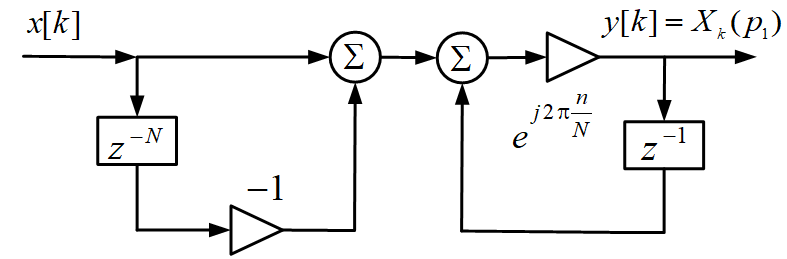

In [36]:
n=18
p=np.exp(2j*np.pi*n/N)
beta=np.zeros(N+1, dtype=complex)
beta[0] = 1
beta[N] = -1
alpha=np.zeros(N+1, dtype=complex)
alpha[0] = 1.0/p
alpha[1] = -1

При обработке последовательности длиной $N$ фильтр возращает $n$-ый отсчет ДПФ в момент времени $N-1$ (в тот же такт, когда поступает последний отсчет сигнала).

In [37]:
y = signal.lfilter(beta, alpha, np.hstack([x, 0.0]))
print(abs(y[N-1]), y[N-1])

20.25546318138307 (20.25546318138307-4.973799150320701e-14j)


Сравним с результатом БПФ

In [38]:
Xn1 = np.fft.fft(x, N)
print(abs(Xn1[n]), Xn1[n])

20.255463181383146 (20.255463181383146-2.6756374893466273e-14j)
